In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef
import FwtModels.RectWing as rw
import FwtModels.RectWing.Models as rwm
import multiprocessing as mp

me.mechanics_printing()

In [2]:
def Gust_Response_WT(model_num,b_modes,t_modes):
    dataset_name = 'WT'
    p = rw.base_params(b_modes + t_modes + 2)
    p.rho.value = 1.225
    p.s_t.value = 1.345
    p.c.value = 0.15
    p.EI.value = 61
    p.GJ.value = 200
    p.rho_t.value = 10
    p.e_0.value = 0
    p.e_1.value = 0
    p.ratio_fwt.value = 0.2
    p.alpha_s.value = np.deg2rad(15)
    p.eta.value = [1]*p.qs
    p.m_ac.value = 1e6
    p.k_ac.value = 1e6
    
    p.w_max = mf.ModelSymbol(value = 0,string = 'p.w_max')
    p.w_T = mf.ModelSymbol(value = 1,string = 'p.w_T')
    
    vars_ls =[]
    vars_ls.append((p.V,[20]))
    vars_ls.append((p.alpha_r,np.deg2rad([4])))
    vars_ls.append((p.m_factor,[1]))
    vars_ls.append((p.c_dmax,np.deg2rad([1])))
    vars_ls.append((p.k_fwt,np.deg2rad([0])))
    vars_ls.append((p.Lambda,np.deg2rad([17.5])))
    
    #Calculate the fixed points
    
    
    
    print(f'M{model_num}-{dataset_name}: Started')
    sm = mf.SymbolicModel.from_file(f'{b_modes}B{t_modes}T-M{model_num}.py')
    
    variables = [k for k,v in vars_ls]
    sm_mini = sm.msubs(p.GetSubs(0,p.fp,ignore=variables))
    L = me.msubs((sm_mini.ExtForces.Q()[0]),{i:0 for i in p.qd})
    L_func = sym.lambdify((p.q,variables),L)
    
    flutdf = rw.fixed_point_finder(p,sm,vars_ls,True,additional_func={'Lift':L_func})
    print(f'M{model_num}-{dataset_name}: Complete')
    flutdf.to_pickle(f'fp_data_{b_modes}B{t_modes}T-M{model_num}_{dataset_name}.pkl')

In [6]:
def Model_Eigen_HALE(model_num,b_modes,t_modes):
    dataset_name = 'HALE'
    p = rw.base_params(b_modes + t_modes + 2)
    p.rho.value = 0.0889
    p.s_t.value = 16
    p.c.value = 1
    p.EI.value = 2e4
    p.GJ.value = 1e4
    p.rho_t.value = 0.75
    p.e_0.value = 0.25
    p.e_1.value = 0
    
    p.ratio_fwt.value = 0.2
    p.alpha_s.value = np.deg2rad(15)
    p.eta.value = [1]*p.qs
    p.m_ac.value = 1e6
    p.k_ac.value = 1e6
    
    vars_ls =[]
    vars_ls.append((p.V,[15,20,25]))
    vars_ls.append((p.alpha_r,np.deg2rad(np.linspace(-5,15,21))))
    vars_ls.append((p.m_factor,[0.5,1,1.5]))
    vars_ls.append((p.c_dmax,np.deg2rad([0,1])))
    vars_ls.append((p.k_fwt,np.deg2rad([0,1e6])))
    vars_ls.append((p.Lambda,np.deg2rad([10,17.5,25])))
    
    print(f'M{model_num}-{dataset_name}: Started')
    sm = mf.SymbolicModel.from_file(f'{b_modes}B{t_modes}T-M{model_num}.py')
    
    variables = [k for k,v in vars_ls]
    sm_mini = sm.msubs(p.GetSubs(0,p.fp,ignore=variables))
    L = me.msubs((sm_mini.ExtForces.Q()[0]),{i:0 for i in p.qd})
    L_func = sym.lambdify((p.q,variables),L)
    
    flutdf = rw.fixed_point_finder(p,sm,vars_ls,True,additional_func={'Lift':L_func})
    print(f'M{model_num}-{dataset_name}: Complete')
    flutdf.to_pickle(f'fp_data_{b_modes}B{t_modes}T-M{model_num}_{dataset_name}.pkl')

In [7]:
def Model_Eigen_JEC(model_num,b_modes,t_modes):
    dataset_name = 'JEC'
    p = rw.base_params(b_modes + t_modes + 2)
    p.rho.value = 1.225
    p.s_t.value = 12
    p.c.value = 1.8
    p.EI.value = 9.77e6
    p.GJ.value = 0.99e6
    p.rho_t.value = 19.53
    p.e_0.value = 0.08
    p.e_1.value = 0  
    p.ratio_fwt.value = 0.2
    
    p.alpha_s.value = np.deg2rad(15)
    p.eta.value = [1]*p.qs
    p.m_ac.value = 1e6
    p.k_ac.value = 1e6
    p.k_fwt.value = 0
    
    vars_ls =[] 
    vars_ls.append((p.V,[30,40,50]))
    vars_ls.append((p.alpha_r,np.deg2rad(np.linspace(-5,15,21))))
    vars_ls.append((p.m_factor,[0.5,1,1.5]))
    vars_ls.append((p.c_dmax,np.deg2rad([0,1])))
    vars_ls.append((p.k_fwt,np.deg2rad([0,1e7])))
    vars_ls.append((p.Lambda,np.deg2rad([10,17.5,25])))
    
    print(f'M{model_num}-{dataset_name}: Started')
    sm = mf.SymbolicModel.from_file(f'{b_modes}B{t_modes}T-M{model_num}.py')
    
    variables = [k for k,v in vars_ls]
    sm_mini = sm.msubs(p.GetSubs(0,p.fp,ignore=variables))
    L = me.msubs((sm_mini.ExtForces.Q()[0]),{i:0 for i in p.qd})
    L_func = sym.lambdify((p.q,variables),L)
    
    flutdf = rw.fixed_point_finder(p,sm,vars_ls,True,additional_func={'Lift':L_func})
    print(f'M{model_num}-{dataset_name}: Complete')
    flutdf.to_pickle(f'fp_data_{b_modes}B{t_modes}T-M{model_num}_{dataset_name}.pkl')

In [8]:
b_modes = 3
t_modes = 3
pool = mp.Pool(mp.cpu_count())

for k in range(8):
    pool.apply_async(Model_Eigen_JEC,args=(k,b_modes,t_modes))
    pool.apply_async(Model_Eigen_HALE,args=(k,b_modes,t_modes))
    pool.apply_async(Model_Eigen_WT,args=(k,b_modes,t_modes))
pool.close()
pool.join()

M0-WT: Started
M0-HALE: Started
M2-JEC: Started
M0-JEC: Started
M1-JEC: Started
M1-WT: Started
M1-HALE: Started
M2-HALE: Started
M0-WT: Complete
M2-WT: Started
M0-JEC: Complete
M3-JEC: Started
M1-WT: Complete
M3-HALE: Started
M1-JEC: Complete
M3-WT: Started
M0-HALE: Complete
M4-JEC: Started
M2-JEC: Complete
M4-HALE: Started
M1-HALE: Complete
M4-WT: Started
M2-HALE: Complete
M5-JEC: Started
M2-WT: Complete
M5-HALE: Started
M3-WT: Complete
M5-WT: Started
M3-JEC: Complete
M6-JEC: Started
M3-HALE: Complete
M6-HALE: Started
M6-JEC: Complete
M6-WT: Started
M6-HALE: Complete
M7-JEC: Started
M5-JEC: Complete
M7-HALE: Started
M5-HALE: Complete
M7-WT: Started
M5-WT: Complete
M7-JEC: Complete
M6-WT: Complete
M7-HALE: Complete
M7-WT: Complete
M4-WT: Complete
M4-JEC: Complete
M4-HALE: Complete


In [3]:
%%time
b_modes = 3
t_modes = 3
Model_Eigen_WT(5,3,3)

M5-WT: Started
M5-WT: Complete
CPU times: user 1min 5s, sys: 480 ms, total: 1min 5s
Wall time: 1min 6s


In [ ]:
df = pd.read_pickle(f'fp_data_{b_modes}B{t_modes}T-M5_WT.pkl')
df.head(5)

In [142]:
b_modes = 3
t_modes = 3
model_num = 5

dataset_name = 'WT'
p = rw.base_params(b_modes + t_modes + 2)
p.rho.value = 1.225
p.s_t.value = 1.345
p.c.value = 0.15
p.EI.value = 61
p.GJ.value = 200
p.rho_t.value = 10
p.e_0.value = 0
p.e_1.value = 0
p.ratio_fwt.value = 0.2
p.alpha_s.value = np.deg2rad(15)
p.eta.value = [1]*p.qs
p.m_ac.value = 1e6
p.k_ac.value = 1e6

p.w_max = mf.ModelSymbol(value = 0,string = 'p.w_max')
p.w_T = mf.ModelSymbol(value = 1,string = 'p.w_T')

vars_ls =[]
vars_ls.append((p.V,[19]))
vars_ls.append((p.alpha_r,np.deg2rad([4])))
vars_ls.append((p.m_factor,[1]))
vars_ls.append((p.c_dmax,[1]))
vars_ls.append((p.k_fwt,[0,1e4]))
vars_ls.append((p.Lambda,np.deg2rad([17.5])))

#Get The Model
print(f'M{model_num}-{dataset_name}: Started')
sm = mf.SymbolicModel.from_file(f'{b_modes}B{t_modes}T-M{model_num}.py')

fp_df = rw.fixed_point_finder(p,sm,vars_ls,False)

#print(f'M{model_num}-{dataset_name}: Complete')
#flutdf.to_pickle(f'fp_data_{b_modes}B{t_modes}T-M{model_num}_{dataset_name}.pkl')

M5-WT: Started


In [143]:
fp_df['Coast Angle [Deg]'] = (np.rad2deg([i[-1] for i in fp_df['q']]))

In [144]:
fp_df['q'][0]

array([ 8.58400803e-07,  8.30241201e-03, -2.73571266e-03,  7.28352525e-05,
        2.96151952e-03, -1.37617078e-03,  6.32390129e-17,  4.21817343e-01])

In [153]:
w_max = [1]
w_T = [2,1.5,1,0.5,0.2]

perms = np.array(np.meshgrid(*[w_max,w_T])).T.reshape(-1,2)
perms[0,1]

variables = [k for k,v in vars_ls]
sm_mini = sm.msubs(p.GetSubs(0,p.fp,ignore=variables+[p.w_g]))
nm = sm_mini.CreateNumericModel(p)

b_shapes = 3
z,_ = mf.ShapeFunctions_BN_TM(b_shapes,0,p.q[1:b_shapes+1],p.y_0,0,0,0,p.eta[1:b_shapes+1])

d2z_dy2 = z.diff(p.y_0,p.y_0).subs(p.y_0,0)
z_tip = z.subs(p.y_0,p.s_0)
dz_dy_tip = z.diff(p.y_0).subs(p.y_0,p.s_0)

d2z_dy2_f = sym.lambdify((p.GetTuple(),p.q),d2z_dy2)
z_tip_f = sym.lambdify((p.GetTuple(),p.q),z_tip)
dz_dy_tip_f = sym.lambdify((p.GetTuple(),p.q),dz_dy_tip)

In [154]:
fp_df

,V,alpha_r,delta_m,c_dmax,k_fwt,Lambda,q,Coast Angle [Deg]
0,19.0,0.069813,1.0,1.0,0.0,0.305433,"[8.584008030366901e-07, 0.00830241200835493, -...",24.168353
1,19.0,0.069813,1.0,1.0,10000.0,0.305433,"[-1.7594053348926987e-06, -0.01755403003612606...",1.262876


In [155]:
ls = []
for att_index in range(len(fp_df)):
    print(f'Attitude {att_index} - Starting')
    for variable in variables:
        variable.value = fp_df[variable.name][att_index]

    for strength,T in perms:
        print(f'Strength {strength}, Period {T} - Starting')
        def gust(t,x):
            if t<T:
                return strength*0.5*(1- np.cos(2*np.pi*t/T))
            else:
                return 0
        p.w_g.value = gust
        def objectiveDeriv(t,y):
            tup = p.GetNumericTuple(y,t)
            return nm.deriv(t,y,tup)

        x = [0]*p.qs*2
        x[::2] = fp_df['q'][att_index]
        yData = solve_ivp(objectiveDeriv,(0,3),x)

        #interpolate
        y_real = yData.y
        t = yData.t
        int_func = interp1d(t,y_real)

        t = np.linspace(0,3,501)
        yi = int_func(t)

        var = fp_df.iloc[att_index].copy().drop(labels = ['q']).to_dict()

        tup = p.GetNumericTuple(None,0)
        wrbm = d2z_dy2_f(tup,yi[::2])*p.EI.value
        inner_tip_deflection = z_tip_f(tup,yi[::2])
        fold_angle = np.rad2deg((yi[-2])+dz_dy_tip_f(tup,yi[::2]))

        for i in range(len(t)):
            lift = nm.ExtForces(p.GetNumericTuple(yi[:,i],t[i]),yi[:,i],t[i])[0,0]

            ls.append({'t':t[i],'q':yi[:,i],'Gust Strength':strength,
                       'Gust Period':T,**var,'Attitude':att_index,
                       'Delta WRBM':wrbm[i]-wrbm[0],
                       'WRBM':wrbm[i],'Inner Tip Deflection':inner_tip_deflection[i],
                      'Fold Angle':fold_angle[i],'Lift':lift})
df = pd.DataFrame(ls)
print('Complete')

Attitude 0 - Starting
Strength 1.0, Period 2.0 - Starting


<string>:41: RuntimeWarning: overflow encountered in exp
<string>:42: RuntimeWarning: invalid value encountered in double_scalars
<string>:46: RuntimeWarning: overflow encountered in exp
<string>:47: RuntimeWarning: invalid value encountered in double_scalars
<string>:50: RuntimeWarning: overflow encountered in exp
<string>:51: RuntimeWarning: invalid value encountered in double_scalars
<string>:54: RuntimeWarning: overflow encountered in exp
<string>:55: RuntimeWarning: invalid value encountered in double_scalars
<string>:58: RuntimeWarning: overflow encountered in exp
<string>:59: RuntimeWarning: invalid value encountered in double_scalars


Strength 1.0, Period 1.5 - Starting
Strength 1.0, Period 1.0 - Starting
Strength 1.0, Period 0.5 - Starting
Strength 1.0, Period 0.2 - Starting
Attitude 1 - Starting
Strength 1.0, Period 2.0 - Starting
Strength 1.0, Period 1.5 - Starting
Strength 1.0, Period 1.0 - Starting
Strength 1.0, Period 0.5 - Starting
Strength 1.0, Period 0.2 - Starting
Complete


In [156]:
df

,t,q,Gust Strength,Gust Period,V,alpha_r,delta_m,c_dmax,k_fwt,Lambda,Coast Angle [Deg],Attitude,Delta WRBM,WRBM,Inner Tip Deflection,Fold Angle,Lift
0,0.000,"[8.584008030366901e-07, 0.0, 0.008302412008354...",1.0,2.0,19.0,0.069813,1.0,1.0,0.0,0.305433,24.168353,0,0.000000,1.012894,0.006302,24.668414,20.650076
1,0.006,"[8.584008037113488e-07, 4.4481854228040664e-13...",1.0,2.0,19.0,0.069813,1.0,1.0,0.0,0.305433,24.168353,0,0.000005,1.012899,0.006302,24.668414,20.651216
2,0.012,"[8.584008139682561e-07, 3.7576542978510986e-12...",1.0,2.0,19.0,0.069813,1.0,1.0,0.0,0.305433,24.168353,0,0.000056,1.012950,0.006302,24.668417,20.654626
3,0.018,"[8.584008627189758e-07, 1.411521718278866e-11,...",1.0,2.0,19.0,0.069813,1.0,1.0,0.0,0.305433,24.168353,0,0.000224,1.013119,0.006302,24.668425,20.660251
4,0.024,"[8.584010085313266e-07, 3.7077040277859765e-11...",1.0,2.0,19.0,0.069813,1.0,1.0,0.0,0.305433,24.168353,0,0.000595,1.013489,0.006302,24.668450,20.667996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5005,2.976,"[-1.40015149127299e-06, -1.2340615130855647e-0...",1.0,0.2,19.0,0.069813,1.0,1.0,10000.0,0.305433,1.262876,1,-0.005270,-2.146861,-0.014733,0.001694,18.030740
5006,2.982,"[-1.4075623769509423e-06, -1.236226020457702e-...",1.0,0.2,19.0,0.069813,1.0,1.0,10000.0,0.305433,1.262876,1,-0.004950,-2.146542,-0.014731,0.001693,18.030597
5007,2.988,"[-1.414986112274215e-06, -1.2383446749136836e-...",1.0,0.2,19.0,0.069813,1.0,1.0,10000.0,0.305433,1.262876,1,-0.004620,-2.146212,-0.014729,0.001694,18.030458
5008,2.994,"[-1.4224224192625015e-06, -1.2404166283968046e...",1.0,0.2,19.0,0.069813,1.0,1.0,10000.0,0.305433,1.262876,1,-0.004282,-2.145874,-0.014727,0.001693,18.030339


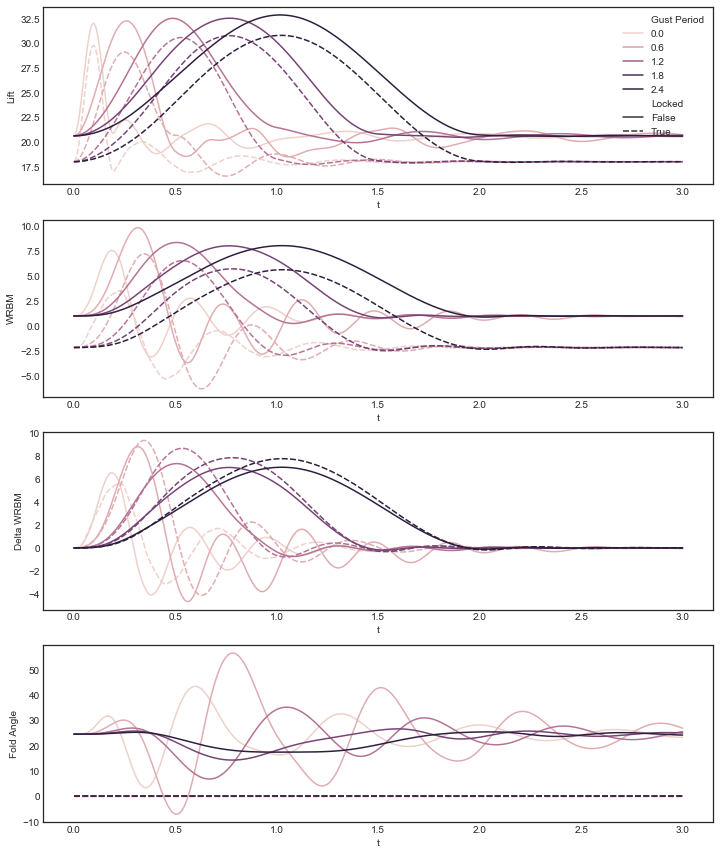

In [161]:
data = df.copy()
data = data[data['Gust Strength']==1]
data['Locked'] = data['k_fwt']>0

fig, axes = plt.subplots(4,1,figsize=(12,15))

sns.lineplot(data = data, x = 't',y='Lift',hue = 'Gust Period',style = 'Locked',ax = axes[0])
sns.lineplot(data = data, x = 't',y='WRBM',hue = 'Gust Period',style = 'Locked',ax = axes[1])
sns.lineplot(data = data, x = 't',y='Delta WRBM',hue = 'Gust Period',style = 'Locked',ax = axes[2])
sns.lineplot(data = data, x = 't',y='Fold Angle',hue = 'Gust Period',style = 'Locked',ax = axes[3])

axes[1].legend([])
axes[2].legend([])
axes[3].legend([])
df['Fold Angle'].max()
